Розмірність початкових даних: (6499, 117)

=== ПОРІВНЯЛЬНА ТАБЛИЦЯ ===
           Метод  Кількість ознак  Точність (Accuracy)  Час навчання (сек)
Оригінальні дані              117                  1.0            0.382066
       Після PCA               40                  1.0            2.820089

Висновок: PCA зменшив кількість ознак у 2.9 разів.


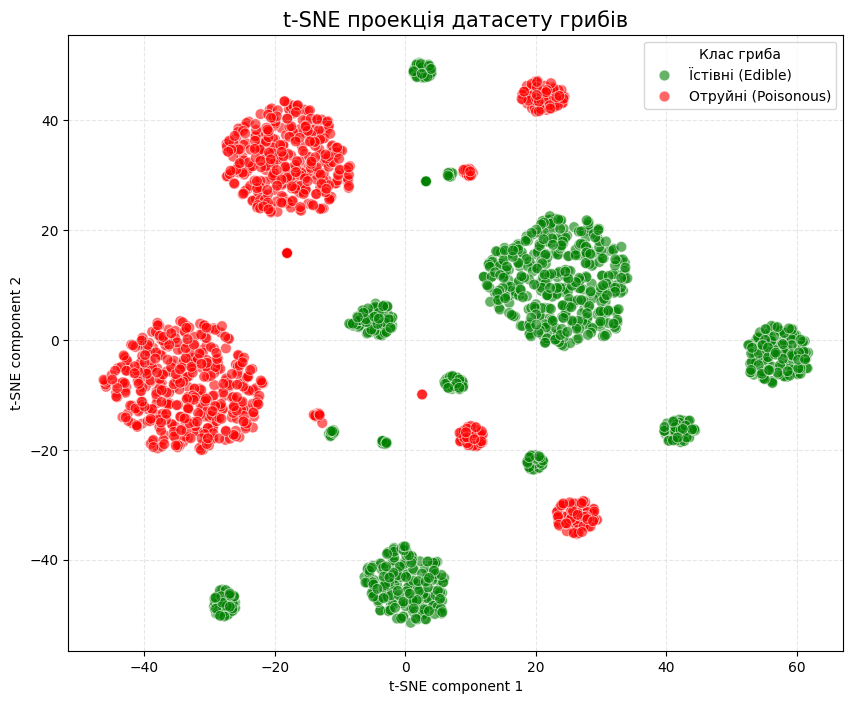

In [16]:
# =====================================================
# === 1. Зниження розмірності і візуалізація даних
# =====================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score

#warnings.filterwarnings("ignore")

# 1. Завантаження та підготовка даних

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"
cols = [
    "class","cap-shape","cap-surface","cap-color","bruises","odor",
    "gill-attachment","gill-spacing","gill-size","gill-color","stalk-shape",
    "stalk-root","stalk-surface-above-ring","stalk-surface-below-ring",
    "stalk-color-above-ring","stalk-color-below-ring","veil-type","veil-color",
    "ring-number","ring-type","spore-print-color","population","habitat"
]

df = pd.read_csv(url, header=None, names=cols)

# Проста обробка пропусків
df = df.replace('?', np.nan)
df['stalk-root'] = df['stalk-root'].fillna('missing')

# Кодування цільової змінної (p - poisonous/отруйний, e - edible/їстівний)
y = df['class'].map({'p': 1, 'e': 0}).astype(int)

# One-Hot Encoding для категоріальних ознак
X = pd.get_dummies(df.drop(columns=['class']), prefix_sep='=')

# Розбиття на Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Розмірність початкових даних: {X_train.shape}")


# 2. Експеримент 1: Оригінальні дані (Random Forest)

clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

start_time = time.time()
clf.fit(X_train, y_train)
train_time_orig = time.time() - start_time

y_pred = clf.predict(X_test)
acc_orig = accuracy_score(y_test, y_pred)
features_orig = X_train.shape[1]


# 3. Експеримент 2: PCA (Збереження 95% дисперсії)

pca = PCA(n_components=0.95, random_state=42)

# Навчаємо PCA тільки на тренувальній вибірці
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

clf_pca = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

start_time = time.time()
clf_pca.fit(X_train_pca, y_train)
train_time_pca = time.time() - start_time

y_pred_pca = clf_pca.predict(X_test_pca)
acc_pca = accuracy_score(y_test, y_pred_pca)
features_pca = X_train_pca.shape[1]


# 4. Порівняння результатів

results = pd.DataFrame({
    'Метод': ['Оригінальні дані', 'Після PCA'],
    'Кількість ознак': [features_orig, features_pca],
    'Точність (Accuracy)': [acc_orig, acc_pca],
    'Час навчання (сек)': [train_time_orig, train_time_pca]
})

print("\n=== ПОРІВНЯЛЬНА ТАБЛИЦЯ ===")
print(results.to_string(index=False))

print(f"\nВисновок: PCA зменшив кількість ознак у {features_orig/features_pca:.1f} разів.")




# Беремо вибірку для пришвидшення (2000 точок достатньо для візуалізації структури)
sample_size = 2000
indices = np.random.RandomState(42).choice(len(X), sample_size, replace=False)
X_subset = X.iloc[indices]
y_subset = y.iloc[indices]

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42, init='pca', learning_rate='auto')
X_tsne = tsne.fit_transform(X_subset)

# Створюємо DataFrame для зручного малювання через Seaborn
tsne_df = pd.DataFrame({
    'x': X_tsne[:, 0],
    'y': X_tsne[:, 1],
    'Label': y_subset.map({0: 'Їстівні (Edible)', 1: 'Отруйні (Poisonous)'})
})

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=tsne_df,
    x='x', y='y',
    hue='Label',
    palette={'Їстівні (Edible)': 'green', 'Отруйні (Poisonous)': 'red'},
    alpha=0.6,
    s=60
)

plt.title('t-SNE проекція датасету грибів', fontsize=15)
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.legend(title='Клас гриба')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()


Розмір зображення: 1432x1416 пікселів
Початок кластеризації (це може зайняти час)...
Обробка 64 кольорів...
Обробка 32 кольорів...
Обробка 16 кольорів...
Обробка 8 кольорів...


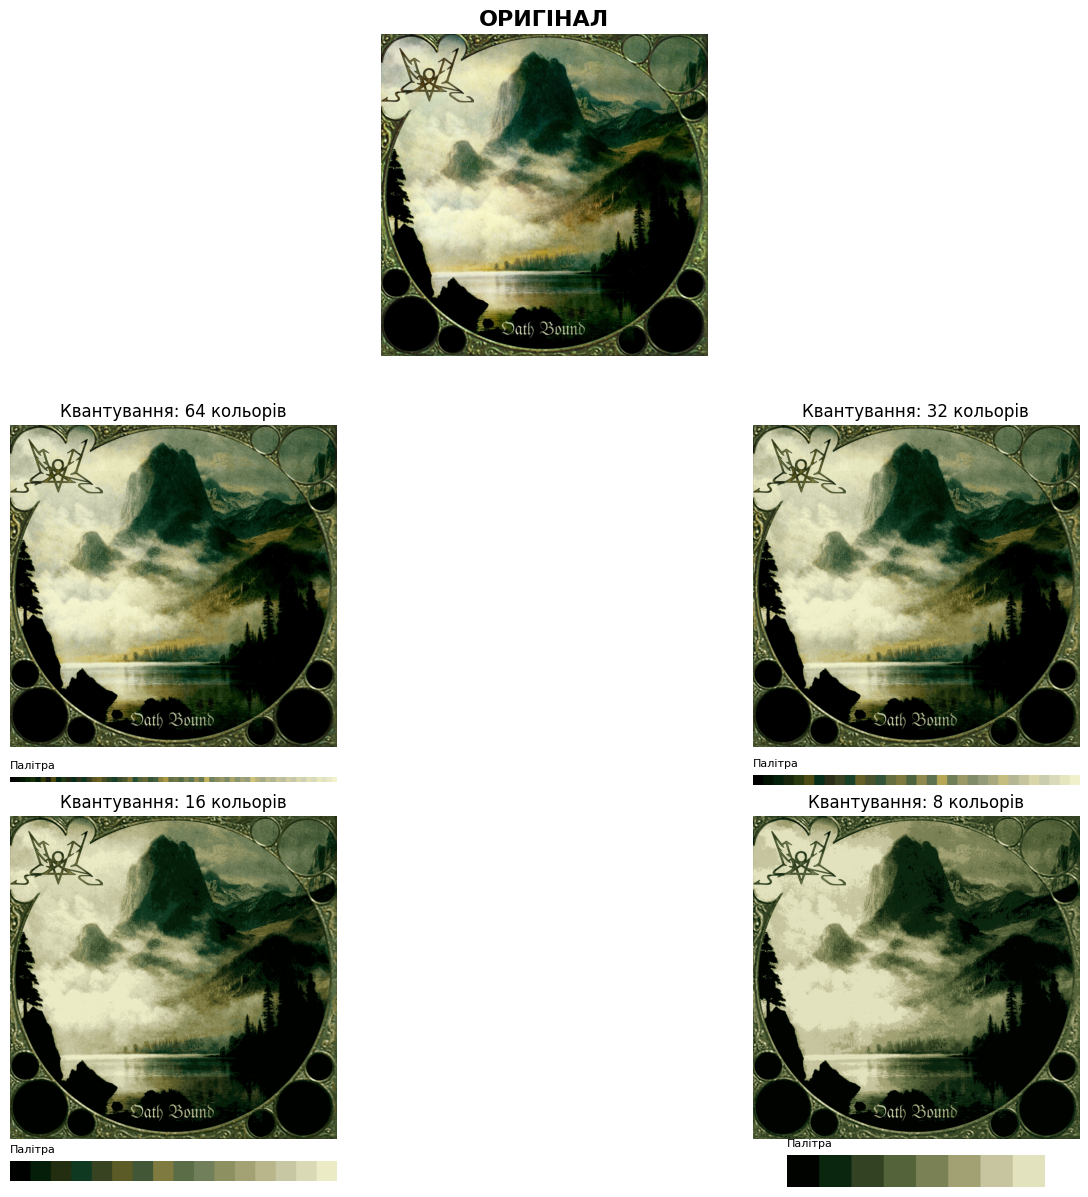

In [9]:
# =====================================================
# === 2. Кластерний аналіз
# =====================================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from PIL import Image
import requests
from io import BytesIO

url = "https://github.com/Khulturg/Labs-IDA2025/raw/main/summoning.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content)).convert('RGB')

#img = img.resize((400, 400))

img_np = np.array(img)
h, w, c = img_np.shape
pixels = img_np.reshape(-1, 3)

print(f"Розмір зображення: {w}x{h} пікселів")


def quantize_image(n_colors, pixels_data):
    """Виконує кластеризацію та повертає нове зображення і центри кольорів"""
    # n_init='auto' значно пришвидшує роботу в нових версіях sklearn
    kmeans = KMeans(n_clusters=n_colors, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(pixels_data)
    centers = kmeans.cluster_centers_.astype('uint8')

    # Відновлюємо зображення з центроїдів
    quantized_img = centers[labels].reshape(h, w, c)
    return quantized_img, centers

def plot_palette(centers, ax):
    """Малює смужку кольорів, які використовуються в зображенні"""
    # Сортуємо кольори для краси (за яскравістю)
    centers = centers[np.lexsort(centers.T)]
    palette = np.zeros((50, 50 * len(centers), 3), dtype='uint8')
    step = 50
    for i, color in enumerate(centers):
        palette[:, i*step:(i+1)*step, :] = color
    ax.imshow(palette)
    ax.axis('off')


levels = [64, 32, 16, 8]

# Створюємо сітку: 3 рядки.
# 1-й рядок - Оригінал (на всю ширину)
# 2-й і 3-й рядки - по 2 зображення
fig = plt.figure(figsize=(15, 12))
gs = fig.add_gridspec(3, 2)

# --- Оригінал ---
ax_orig = fig.add_subplot(gs[0, :]) # Займає обидві колонки першого рядка
ax_orig.imshow(img_np)
ax_orig.set_title("ОРИГІНАЛ", fontsize=16, fontweight='bold')
ax_orig.axis('off')

# --- Оброблені зображення ---
print("Початок кластеризації (це може зайняти час)...")

positions = [(1, 0), (1, 1), (2, 0), (2, 1)] # Координати в сітці

for (row, col), n_colors in zip(positions, levels):
    print(f"Обробка {n_colors} кольорів...")
    q_img, centers = quantize_image(n_colors, pixels)

    ax = fig.add_subplot(gs[row, col])
    ax.imshow(q_img)
    ax.set_title(f"Квантування: {n_colors} кольорів", fontsize=12)
    ax.axis('off')

    # Додаємо маленьку палітру внизу картинки (через inset_axes)
    # Це створює "підпис" кольорами
    ax_inset = ax.inset_axes([0.0, -0.15, 1.0, 0.1]) # [x, y, width, height]
    plot_palette(centers, ax_inset)
    ax_inset.set_title("Палітра", fontsize=8, loc='left')

plt.tight_layout()
plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Завантаження даних...
Дані завантажено. Загальна кількість: 18000
category
reddit    9000
wocka     9000
Name: count, dtype: int64
Очищення завершено. Приклад:
                                                text  \
0  How will Hillary Clinton keep the economy up? ...   
1          People: Are you single? me: no i'm Album    

                                  cleaned_text  
0  hillary clinton keep economy wont secretary  
1                       people single im album  


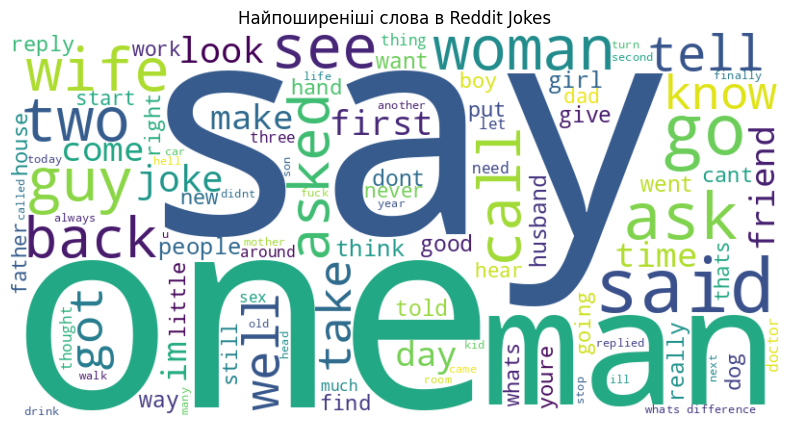

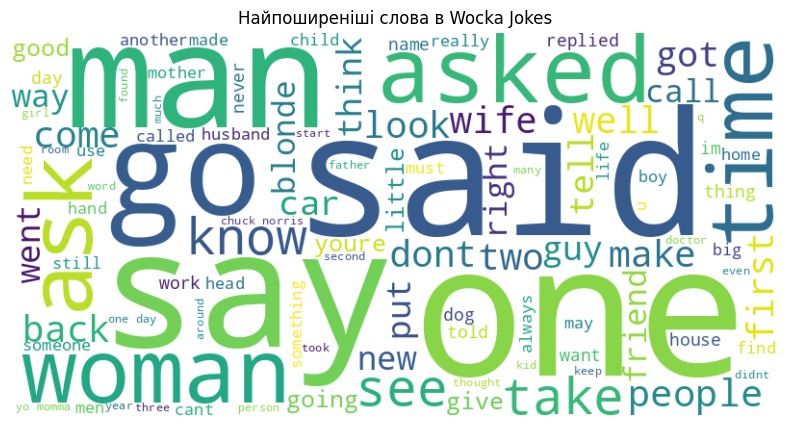


Навчання моделі...

РЕЗУЛЬТАТИ КЛАСИФІКАЦІЇ:
Точність (Accuracy): 0.7522

Звіт класифікації:
              precision    recall  f1-score   support

      reddit       0.74      0.78      0.76      1800
       wocka       0.77      0.72      0.74      1800

    accuracy                           0.75      3600
   macro avg       0.75      0.75      0.75      3600
weighted avg       0.75      0.75      0.75      3600



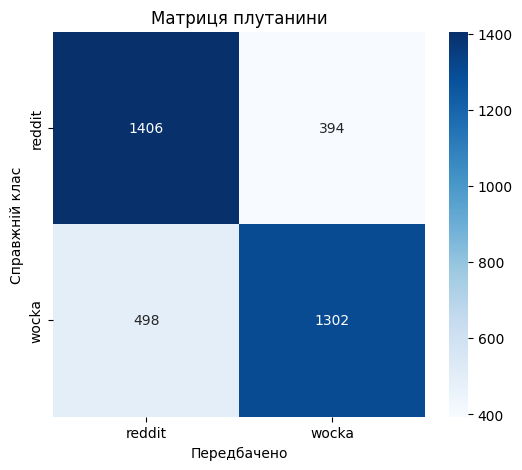

In [5]:
# =====================================================
# === 3. Аналіз твітів (класифікація настроїв)
# =====================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import requests
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Завантаження необхідних пакетів NLTK
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# ==========================================
# 1. ЗАВАНТАЖЕННЯ ДАНИХ
# ==========================================
print("Завантаження даних...")


url_reddit = "https://raw.githubusercontent.com/taivop/joke-dataset/master/reddit_jokes.json"
url_wocka = "https://raw.githubusercontent.com/taivop/joke-dataset/master/wocka.json"


data_reddit = requests.get(url_reddit).json()
data_wocka = requests.get(url_wocka).json()


df_reddit = pd.DataFrame(data_reddit)
df_wocka = pd.DataFrame(data_wocka)


df_reddit['category'] = 'reddit'
df_wocka['category'] = 'wocka'

df_reddit['text'] = df_reddit['title'] + " " + df_reddit['body']

df_wocka['text'] = df_wocka['body']


df_reddit = df_reddit[['text', 'category']]
df_wocka = df_wocka[['text', 'category']]

# --- БАЛАНСУВАННЯ КЛАСІВ ---
# Reddit має набагато більше даних, ніж Wocka. Щоб модель не перенавчилася,
# візьмемо однакову кількість записів
sample_size = 9000
df_reddit = df_reddit.sample(n=sample_size, random_state=42)
df_wocka = df_wocka.sample(n=min(sample_size, len(df_wocka)), random_state=42)

# Об'єднання в один датасет
df = pd.concat([df_reddit, df_wocka], ignore_index=True)

# Перемішуємо дані
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Дані завантажено. Загальна кількість: {len(df)}")
print(df['category'].value_counts())

# ==========================================
# 2. ПЕРЕДОБРОБКА ДАНИХ
# ==========================================

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # 1. Приведення до нижнього регістру
    text = str(text).lower()

    # 2. Видалення пунктуації та спецсимволів (залишаємо тільки букви)
    text = re.sub(r'[^a-z\s]', '', text)

    # 3. Токенізація (розбиття на слова)
    words = text.split()

    # 4. Видалення стоп-слів та лематизація (приведення до початкової форми)
    cleaned_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

    return " ".join(cleaned_words)

# Застосовуємо функцію до всього стовпця
df['cleaned_text'] = df['text'].apply(preprocess_text)

print("Очищення завершено. Приклад:")
print(df[['text', 'cleaned_text']].head(2))

# ==========================================
# 3. ВІЗУАЛІЗАЦІЯ (WordCloud)
# ==========================================

def plot_wordcloud(text_data, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(str(text_data))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Хмара слів для Reddit
reddit_text = " ".join(df[df['category'] == 'reddit']['cleaned_text'])
plot_wordcloud(reddit_text, "Найпоширеніші слова в Reddit Jokes")

# Хмара слів для Wocka
wocka_text = " ".join(df[df['category'] == 'wocka']['cleaned_text'])
plot_wordcloud(wocka_text, "Найпоширеніші слова в Wocka Jokes")

# ==========================================
# 4. ВЕКТОРИЗАЦІЯ ТА КЛАСИФІКАЦІЯ
# ==========================================
print("\nНавчання моделі...")

# Розділення на тренувальну та тестову вибірки (80% на 20%)
X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned_text'],
    df['category'],
    test_size=0.2,
    random_state=42,
    stratify=df['category'] # Зберігаємо пропорції класів
)

# Векторизація (TF-IDF)
# max_features=5000 - беремо топ 5000 слів
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 1))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Модель: Логістична Регресія (добре працює з текстами)
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

# Передбачення
y_pred = model.predict(X_test_tfidf)

# ==========================================
# 5. ОЦІНКА ЯКОСТІ
# ==========================================
print("\nРЕЗУЛЬТАТИ КЛАСИФІКАЦІЇ:")
print(f"Точність (Accuracy): {accuracy_score(y_test, y_pred):.4f}")
print("\nЗвіт класифікації:")
print(classification_report(y_test, y_pred))

# Матриця плутанини (Confusion Matrix)
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Передбачено')
plt.ylabel('Справжній клас')
plt.title('Матриця плутанини')
plt.show()